In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
import time
from tqdm.auto import tqdm
import glob
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib
import uproot_methods

from utils import set_plotting_style, numba_histogram, numba_histogram2d, make_profile, get_chunking, get_chunking_dask
import utils

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
set_plotting_style()

In [3]:
# pixel modules are "rectangular" since first shape element == 2
# https://github.com/cms-sw/cmssw/blob/29bb6d50266b08946dca4f74108e0fc76ca38754/Fireworks/Geometry/src/FWRecoGeometryESProducer.cc#L568

# https://github.com/cms-sw/cmssw/blob/982c595daa9fdde39b7a5925f706b457b178607d/Fireworks/Core/src/FWGeometry.cc
# https://github.com/cms-sw/cmssw/blob/29bb6d50266b08946dca4f74108e0fc76ca38754/Fireworks/Geometry/src/FWRecoGeometryESProducer.cc#L552

def get_geometry_df(fname):
    f = uproot.open(fname)
    t = f["idToGeo"]
    
    df = t.pandas.df(branches=["shape","translation","matrix"],flatten=False)
    df["translation_x"] = df["translation"].str[0]
    df["translation_y"] = df["translation"].str[1]
    df["translation_z"] = df["translation"].str[2]
    df["translation_rho"] = np.hypot(df["translation_x"],df["translation_y"])

    df = df[df["shape"].apply(lambda x:x[0])==2.]

    # one z slice of barrel
    # df = df.query("0<translation_z<10")
    # 4 pixel layers
    df = df.query("translation_rho<18")
    return df

gdf = get_geometry_df("/home/users/namin/2019/scouting/repo/geometry/tracker_geometry_data2018.root")

gdf_mc = get_geometry_df("/home/users/namin/2019/scouting/repo/geometry/tracker_geometry_mc2018.root")
gdf_data = get_geometry_df("/home/users/namin/2019/scouting/repo/geometry/tracker_geometry_data2018.root")

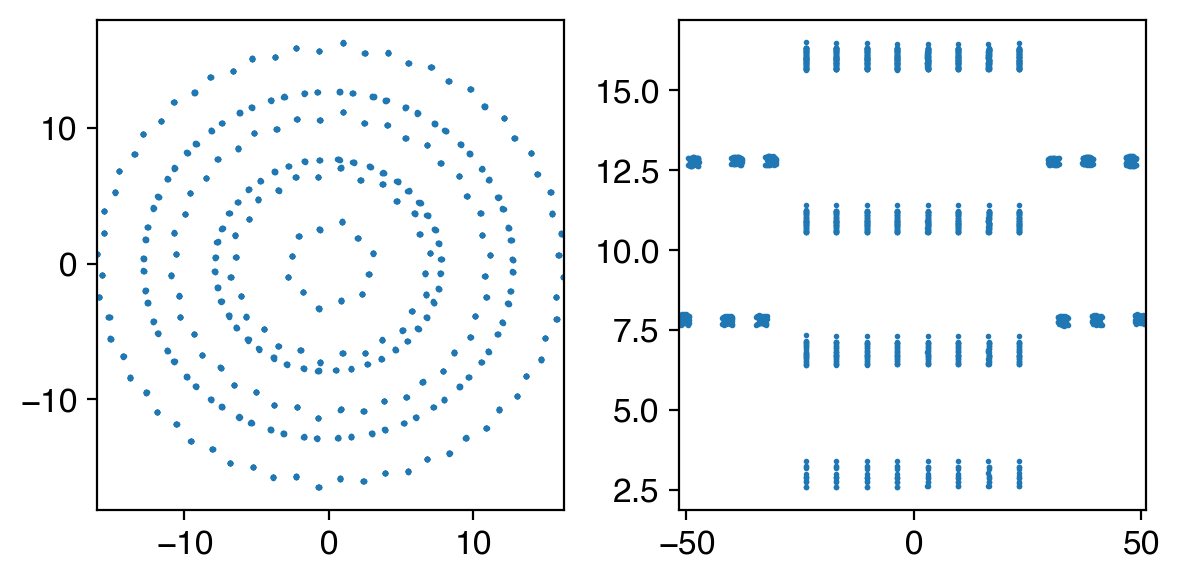

In [4]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
ax1.scatter(
    gdf.translation_x,
    gdf.translation_y,
    s=1,
);

ax2.scatter(
    gdf.translation_z,
    gdf.translation_rho,
    s=1,
);
fig.set_tight_layout(True)

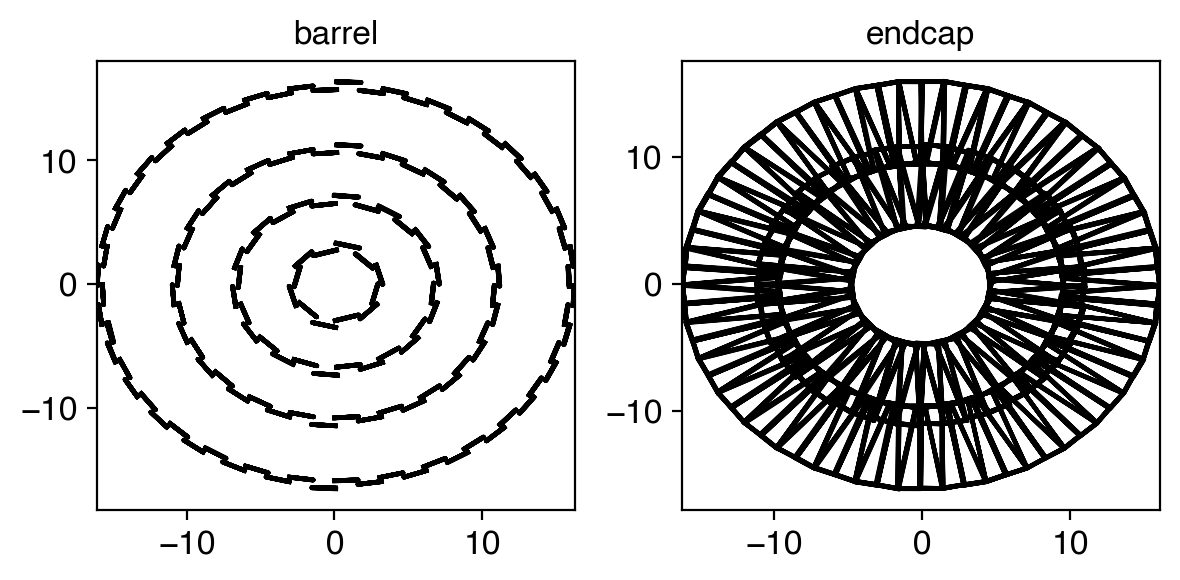

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

# shape is (2, halfwidth,halflength,halfthickness)
# triplets of [0,0,0], [0,0,1], ... counting up to 8
binary_triplets = np.unpackbits(np.arange(8,dtype=np.uint8)[:,np.newaxis],1)[:,-3:].astype(int)
# convert 0->-1 and 1->1
step_directions = binary_triplets*2-1

for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    # make 8 points by stepping away from 0,0,0 by the half-lengths in all 8 directions, then transform
    points = shape.T * step_directions
    points = np.array([np.dot(matrix,point)+translation for point in points])
    
    # reorder so endcap looks prettier
    points = points[np.array([0,4,6,2,1,5,7,3])]

    ax = ax2 if (abs(entry.translation_z) > 27) else ax1
    ax.plot(points[:,0],points[:,1],color="k")

ax1.set_title("barrel")
ax2.set_title("endcap")
fig.set_tight_layout(True)

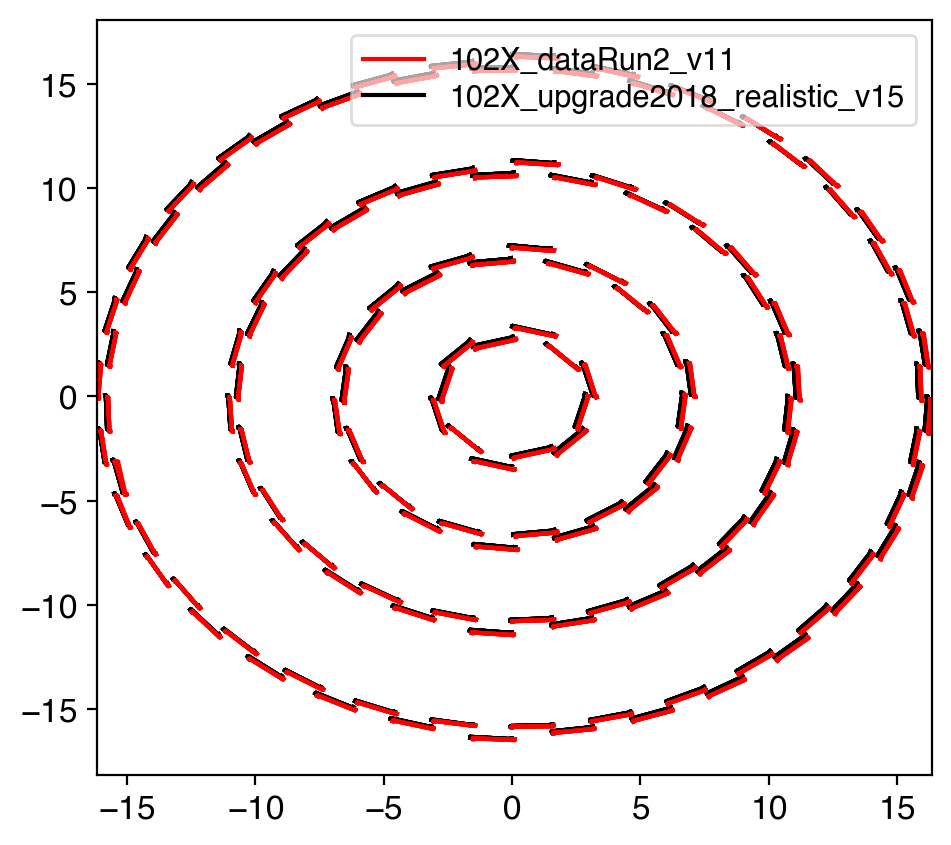

In [6]:
fig,ax = plt.subplots(figsize=(5,5))

for irow,entry in gdf_mc.query("abs(translation_z)<17").iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    # make 8 points by stepping away from 0,0,0 by the half-lengths in all 8 directions, then transform
    points = shape.T * step_directions
    points = np.array([np.dot(matrix,point)+translation for point in points])
    
    ax.plot(points[:,0],points[:,1],color="k")

for irow,entry in gdf_data.query("abs(translation_z)<17").iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    # make 8 points by stepping away from 0,0,0 by the half-lengths in all 8 directions, then transform
    points = shape.T * step_directions
    points = np.array([np.dot(matrix,point)+translation for point in points])
    
    ax.plot(points[:,0],points[:,1],color="r")
    
ax.plot(0,0,color="r",label="102X_dataRun2_v11")
ax.plot(0,0,color="k",label="102X_upgrade2018_realistic_v15")
ax.legend()

In [7]:
data = []

(-20, 20)

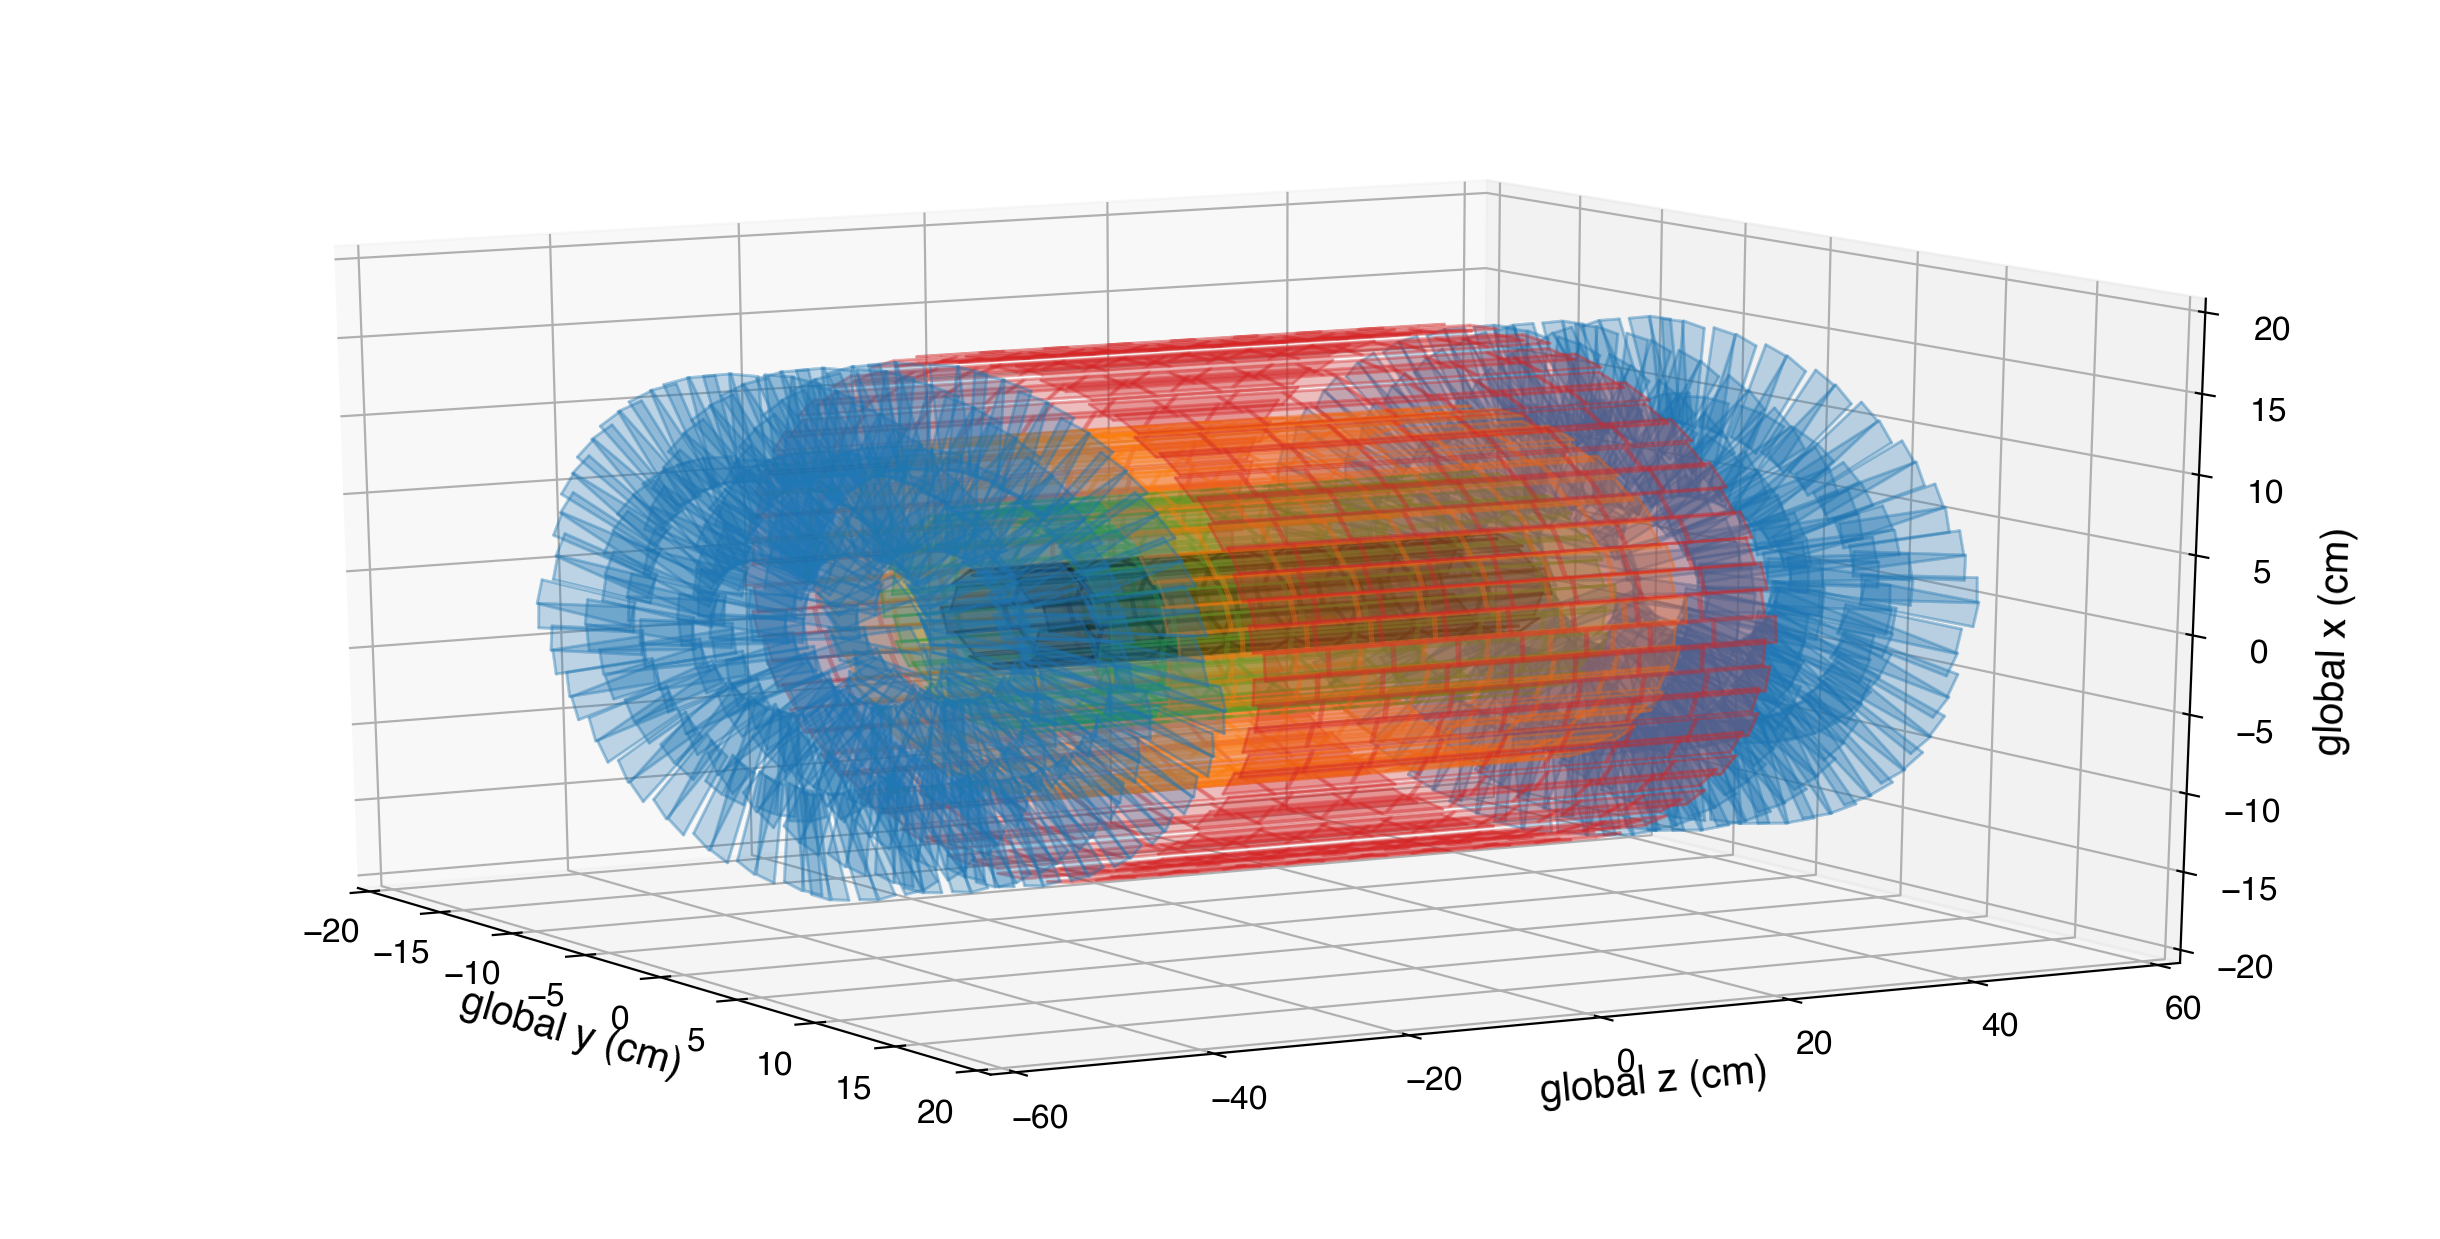

In [8]:
# %matplotlib notebook
# enables interactivity

fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)

ax = Axes3D(fig,azim=-30,elev=15)

for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

#     newshape = np.array(shape)
#     newshape[-1] += 0.2 # add 0.2cm to the thickness
#     shape = newshape
    
    points = shape.T * step_directions

    newpoints = np.array([np.dot(matrix,point)+translation for point in points])

    # edges of each face shouldn't cross, so we look at our binary matrix
    # and get the indices of elements which will give an ordering that goes CCW
    # (e.g., for fixed z (3rd column=0 or 1), xy should do 00,10,11,01)
    faces = [
        newpoints[np.array([0,2,3,1])],
        newpoints[np.array([4,6,7,5])],
        newpoints[np.array([0,4,5,1])],
        newpoints[np.array([2,6,7,3])],
        newpoints[np.array([0,4,6,2])],
        newpoints[np.array([1,5,7,3])],
    ]
    faces = np.array(faces)
    
    data.append(faces)
    
    # rotate x,y,z because I can't make matplotlib z axis go horizontally
    newfaces = np.array(faces)
    newfaces[:,:,0] = faces[:,:,1] # CMS x->plot y
    newfaces[:,:,1] = faces[:,:,2] # CMS y->plot z
    newfaces[:,:,2] = faces[:,:,0] # CMS z->plot x
    faces = newfaces
    
    color = "C3"
    if abs(entry.translation_z) > 27:
        color = "C0" 
    elif entry.translation_rho < 5:
        color = "k"
    elif entry.translation_rho < 10:
        color = "C2"
    elif entry.translation_rho < 15:
        color = "C1"
    ax.add_collection3d(Poly3DCollection(faces,alpha=0.15,color=color))

ax.grid()
ax.set_xlabel("global y (cm)")
ax.set_ylabel("global z (cm)")
ax.set_zlabel("global x (cm)")

ax.set_xlim([-20,20])
ax.set_ylim([-60,60]) # matplotlib y is actually CMS z
ax.set_zlim([-20,20])

In [9]:
np.array(data).dump("pixelfaces.npy")

In [10]:
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed
scheduler_url = "uaf-10.t2.ucsd.edu:50123"
c = Client(scheduler_url)
# c.restart()
c

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 50 Cores: 50 Memory: 250.00 GB


In [11]:
fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018*-v1_RAW_v4skim1cm/*.root"))
import random
random.Random(4).shuffle(fnames)
fnames = fnames[:None]
# chunks, total_nevents = get_chunking(tuple(fnames),int(1.5e6))
chunks, total_nevents = get_chunking_dask(tuple(fnames),int(2.5e6), client=c)
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

602 chunks of 602 files, with a total of 6.3429e+07 events


In [46]:
def get_hists(chunk):
    fname,entrystart,entrystop = chunk
    extra = dict(namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
    edgesz,edgesrho = np.linspace(-50,50,200),np.linspace(0,20,200)
    boxes = [
        [[2.5,3.5],[-23,23]],
        [[6.3,7.4],[-27,27]],
        [[10.3,11.5],[-27,27]],
        [[15.5,16.5],[-27,27]],

        [[9,16.5],[29,33]],
        [[9,16.5],[-29,-33]],

        [[9,16.5],[36,39.5]],
        [[9,16.5],[-36,-39.5]],
    ]
    try:
        t = uproot.open(fname)["Events"]
        arrs = t.arrays(["DV_x","DV_y","DV_z"],**extra)
        dvx = arrs["DV_x"].content
        dvy = arrs["DV_y"].content
        dvz = arrs["DV_z"].content
        dvrho = np.hypot(dvx,dvy)
        is_inside = np.zeros_like(dvrho).astype(bool)
        for (rho1,rho2),(z1,z2) in boxes:
            rholow,rhohigh = sorted([rho1,rho2])
            zlow,zhigh = sorted([z1,z2])
            is_inside |= ((rholow < dvrho) & (dvrho < rhohigh) & (zlow < dvz) & (dvz < zhigh))
        sel = is_inside
#         sel = is_inside | (~is_inside)
#         sel = ~is_inside
        counts_xy = np.histogram2d(dvx[sel],dvy[sel],bins=[edgesx,edgesy])[0]
        counts_zrho = np.histogram2d(dvz[sel],dvrho[sel],bins=[edgesz,edgesrho])[0]
    except:
        counts_xy = np.zeros((len(edgesx)-1,len(edgesy)-1))
        counts_zrho = np.zeros((len(edgesz)-1,len(edgesrho)-1))
    return counts_xy,counts_zrho

h1,h2 = get_hists((chunks[0][0],chunks[0][1],10000))
h1.sum(), h2.sum()

(1335.0, 1335.0)

In [47]:
# c.submit(get_hists,chunks[0]).result()[0].sum()

In [48]:
futures = c.map(get_hists,chunks)

progress(futures)

VBox()

In [49]:
results = c.gather(futures)

xy = sum(r[0] for r in results)
rhoz = sum(r[1] for r in results)

In [50]:
# xy.max()/1e9
rhoz.max()

28622.0

9.33e+06


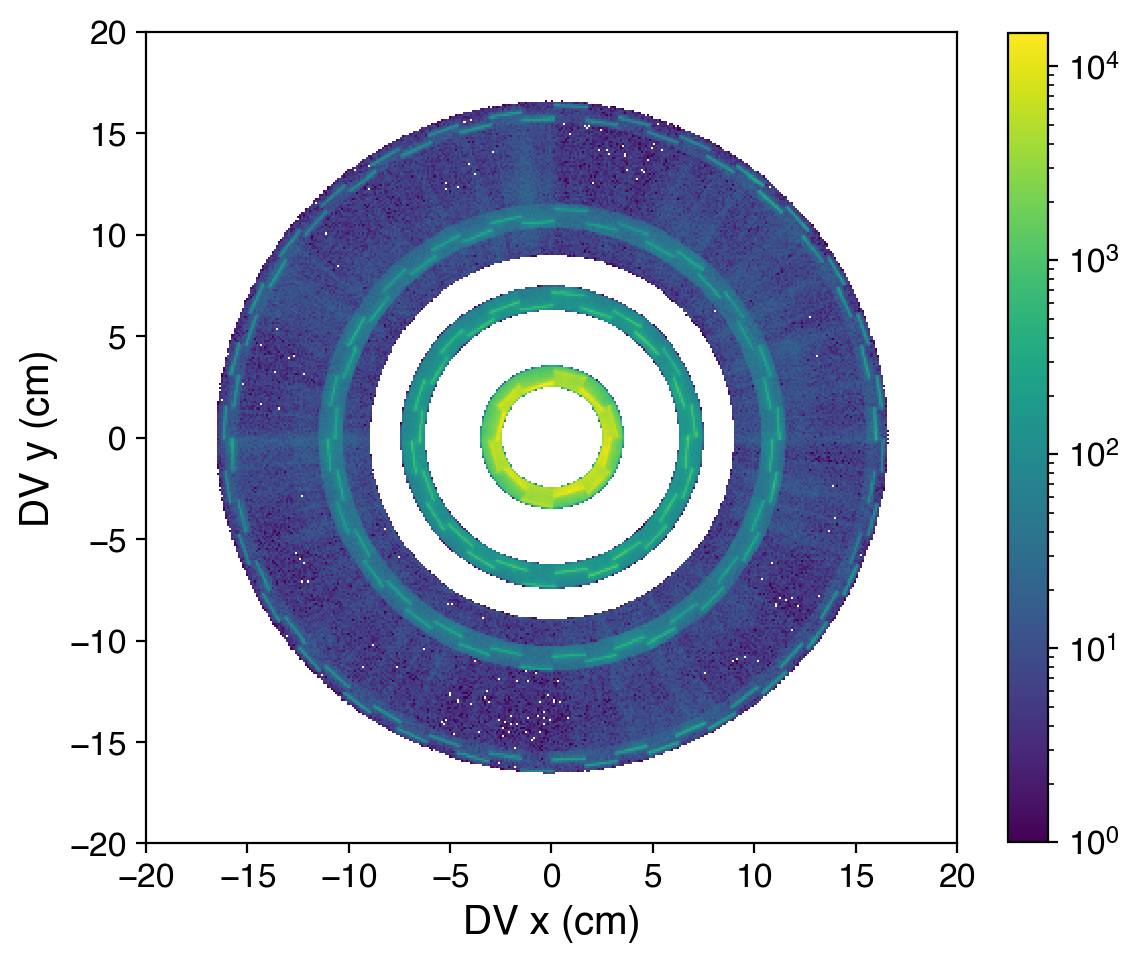

In [51]:
# sad, no 2d hist with dask: https://github.com/dask/dask/blob/94c6b16581828c3fb6c31f1af6d795e7cb02f54c/dask/array/routines.py#L638
edgesx,edgesy = np.linspace(-20,20,400),np.linspace(-20,20,400)
print("{:.3g}".format(xy.sum()))

fig,ax = plt.subplots(figsize=(6,6))
H = ax.imshow(
    xy[::,::-1].T,norm=LogNorm(),extent=[
        edgesx[0],edgesx[-1],
        edgesy[0],edgesy[-1]
    ],
    interpolation="none",
      )
fig.colorbar(H,ax=ax,shrink=0.71)

ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")
fig.set_tight_layout(True)

CPU times: user 75 ms, sys: 2 ms, total: 77 ms
Wall time: 75.4 ms


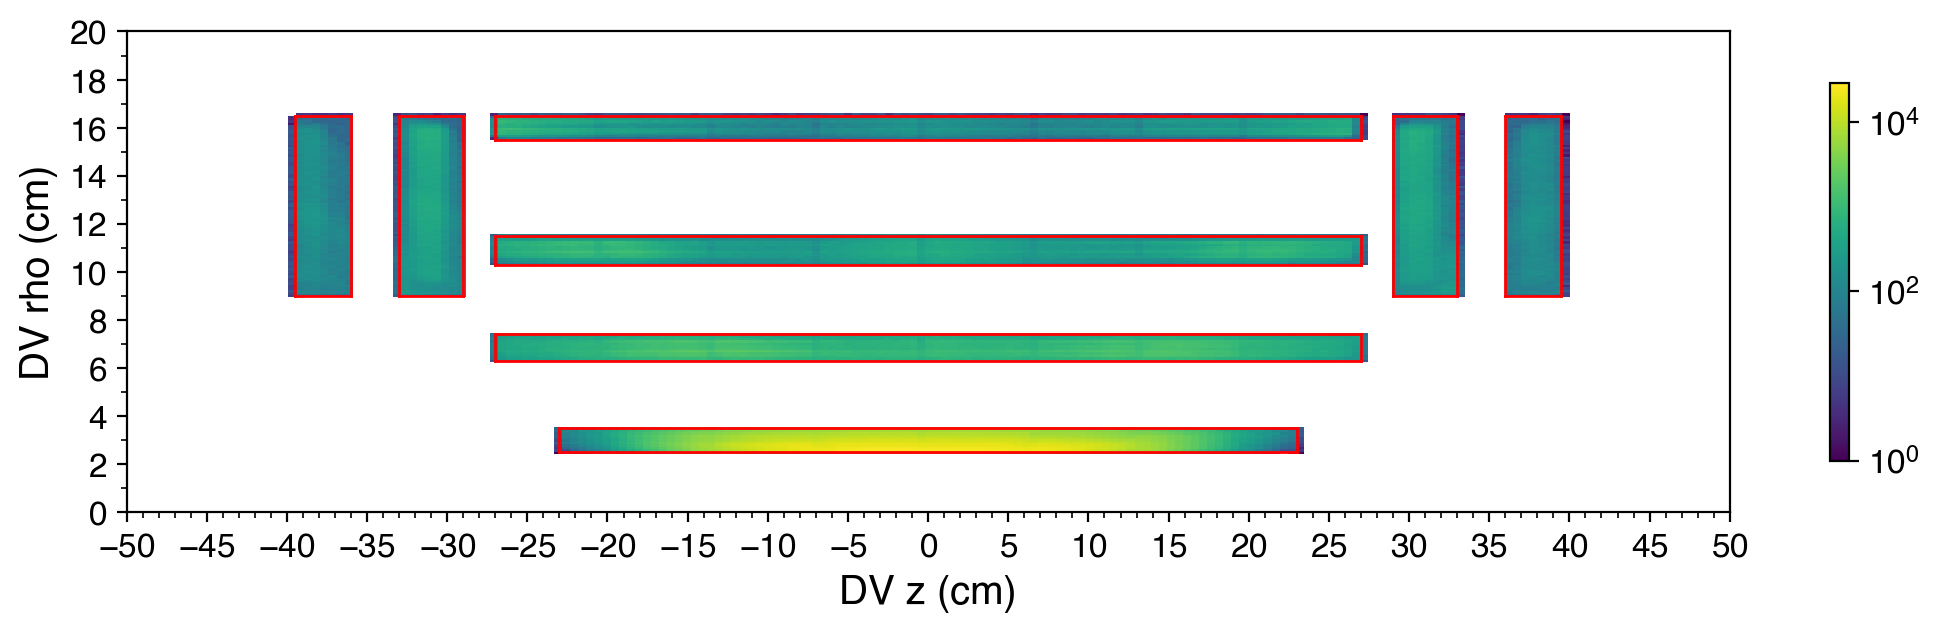

In [52]:

%%time
edgesz,edgesrho = np.linspace(-50,50,200),np.linspace(0,20,200)
fig,ax = plt.subplots(figsize=(12,10))
# fig,ax = plt.subplots(figsize=(10,22))
H = ax.imshow(
    rhoz.T[::-1],
    norm=LogNorm(),
    interpolation="none",
    extent=[
        edgesz[0],edgesz[-1],
        edgesrho[0],edgesrho[-1]
        ]
      )

boxes = [
    [[2.5,3.5],[-23,23]],
    [[6.3,7.4],[-27,27]],
    [[10.3,11.5],[-27,27]],
    [[15.5,16.5],[-27,27]],
    
    [[9,16.5],[29,33]],
    [[9,16.5],[-29,-33]],
    
    [[9,16.5],[36,39.5]],
    [[9,16.5],[-36,-39.5]],
]
    


for (rho1,rho2),(z1,z2) in boxes:
    ax.plot([z1,z2],[rho1,rho1],color="r",lw=1)
    ax.plot([z1,z1],[rho1,rho2],color="r",lw=1)
    ax.plot([z1,z2],[rho2,rho2],color="r",lw=1)
    ax.plot([z2,z2],[rho1,rho2],color="r",lw=1)
    
ax.set_aspect(1.5)
fig.colorbar(H,ax=ax,shrink=0.25)
ax.set_ylabel("DV rho (cm)")
ax.set_xlabel("DV z (cm)")

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))

In [56]:
@delayed
def get_chunk(chunk):
    fname,entrystart,entrystop = chunk
    import pandas as pd
    df = pd.DataFrame()
    try:
        f = uproot.open(fname)
        t = f["Events"]
        df["DV_x"] = t.array("DV_x",entrystart=entrystart,entrystop=entrystop)[:,0]
        df["DV_y"] = t.array("DV_y",entrystart=entrystart,entrystop=entrystop)[:,0]
        df["DV_z"] = t.array("DV_z",entrystart=entrystart,entrystop=entrystop)[:,0]
    except:
        pass
    return df
    
df = get_chunk(chunks[0]).compute()
df.head()

,DV_x,DV_y,DV_z
0,0.999401,0.135400,-3.317009
1,-0.184042,1.077991,-7.285197
2,-1.200977,-0.040874,2.105905
3,1.138191,0.183348,-3.104604
4,-1.204850,-0.156749,1.416913


In [57]:
df = dd.from_delayed(map(get_chunk,chunks)).persist()

In [58]:
df.shape[0].compute()/1e9

0.063429171

In [59]:
# bins = np.linspace(-8,8,200)
bins = np.linspace(-15,15,200)
fedgesx, fedgesy = lambda:bins,lambda:bins
# edgesx, edgesy = np.linspace(-5,5,200),np.linspace(-5,5,200)
@delayed
def f(d):
    x = d["DV_x"]
    y = d["DV_y"]
    z = d["DV_z"]
    rho = np.hypot(x,y)
#     sel = (rho > 2.2) & (rho < 4.5) & (np.abs(z) < 25)
#     sel = (rho > 6.2) & (rho < 7.5) & (np.abs(z) < 25)
#     sel = (rho > 10) & (rho < 12) & (np.abs(z) < 25)
    sel = np.ones(len(x))>0
    try:
        counts = np.histogram2d(x[sel],y[sel],bins=[fedgesx(),fedgesy()])[0]
    except:
        counts = np.zeros((len(fedgesx())-1,len(fedgesy())-1))
    return counts
    
xy = delayed(sum)(map(f,df.to_delayed())).compute()


CPU times: user 54 ms, sys: 5 ms, total: 59 ms
Wall time: 54.3 ms


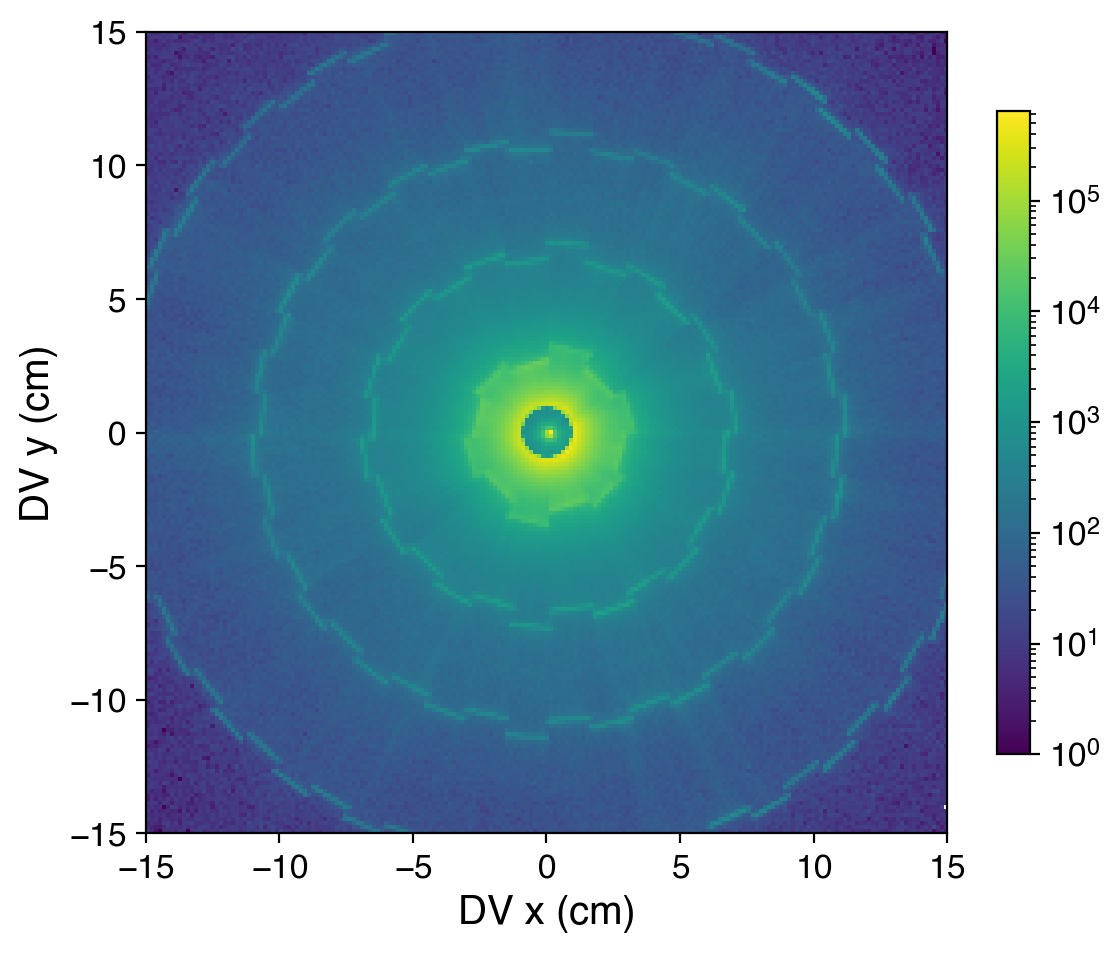

In [60]:
%%time
fig,ax = plt.subplots(figsize=(6,6))
H = ax.imshow(
    xy[::,::-1].T,
    norm=LogNorm(),
    extent=[
        fedgesx()[0],fedgesx()[-1],
        fedgesy()[0],fedgesy()[-1]
    ],
    interpolation="none",
      )
fig.colorbar(H,ax=ax,shrink=0.71)

_ = ax.set_ylabel("DV y (cm)")
_ = ax.set_xlabel("DV x (cm)")

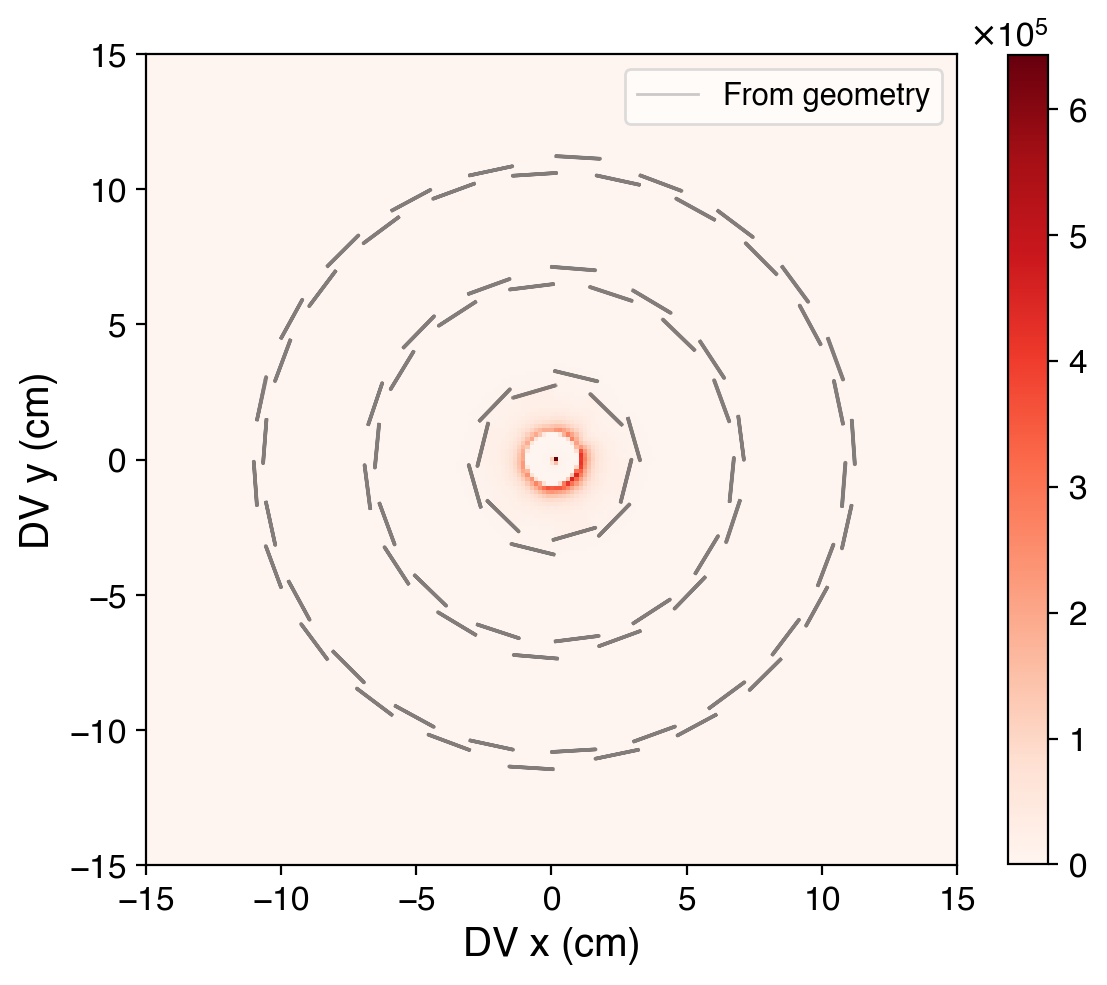

In [61]:

fig,ax = plt.subplots(figsize=(6,6))
H = ax.imshow(
#     xy[::,::-1],
    xy[::,::-1].T,
#     norm=LogNorm(),
    cmap="Reds",
#     cmap="Greys",
    extent=[
        fedgesx()[0],fedgesx()[-1],
        fedgesy()[0],fedgesy()[-1]
    ],
    interpolation="none",
      )
fig.colorbar(H,ax=ax,shrink=0.71)

binary_triplets = np.unpackbits(np.arange(8,dtype=np.uint8)[:,np.newaxis],1)[:,-3:].astype(int)
step_directions = binary_triplets*2-1
first = True
# for irow,entry in gdf.query("abs(translation_z)<10 and 6<translation_rho<8").iterrows():
for irow,entry in gdf.query("abs(translation_z)<10 and translation_rho<15").iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    shape = np.array(shape.T)
#     shape[-1] += 0.2
    points = shape * step_directions
    points = np.array([np.dot(matrix,point)+translation for point in points])
    extra = {}
    if first:
        extra = dict(label="From geometry")
        first = False
    # reorder so endcap looks prettier
    points = points[np.array([0,4,6,2,1,5,7,3])]
    ax.plot(points[:,0],points[:,1],color="k", alpha=0.2, lw=1,**extra)

ax.legend()
ax.set_ylabel("DV y (cm)")
ax.set_xlabel("DV x (cm)")
fig.set_tight_layout(True)

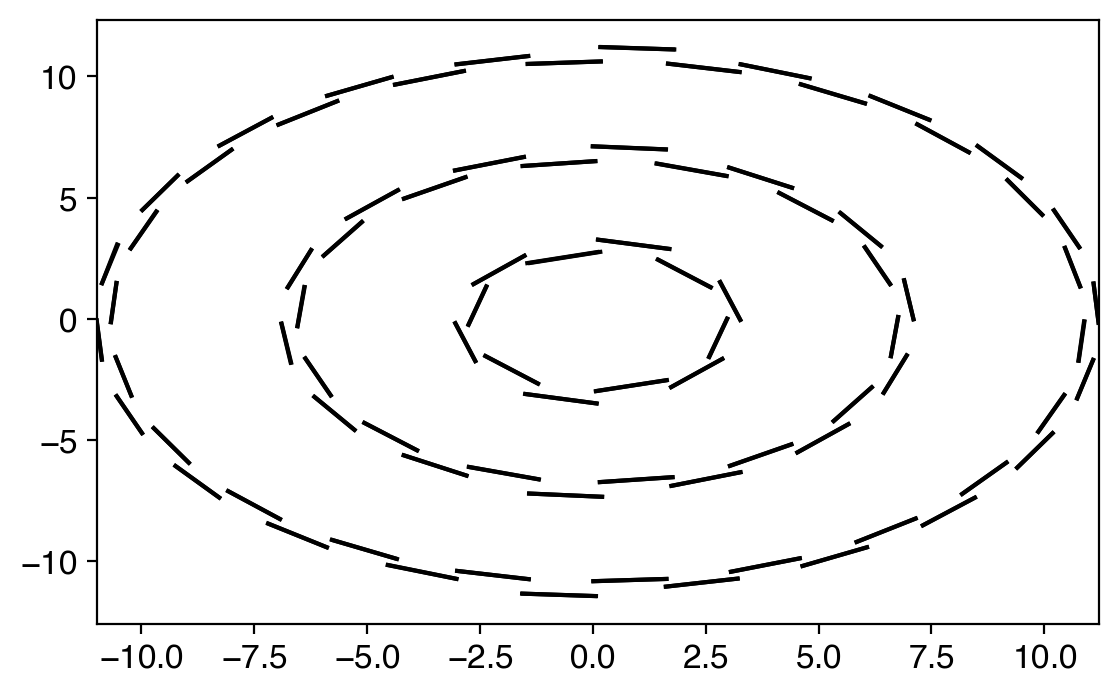

In [62]:
fig,ax = plt.subplots()
utils.plot_overlay_bpix(ax=ax)

In [63]:
%%time
df["DV_x"].mean().compute()

CPU times: user 489 ms, sys: 15 ms, total: 504 ms
Wall time: 2.06 s


0.1708639295518057

In [64]:
df.shape

(Delayed('int-2454604b-7a5f-4cb3-aa16-20304d33610e'), 3)

In [70]:
%%time
len(df)

CPU times: user 139 ms, sys: 7 ms, total: 146 ms
Wall time: 985 ms


63429171

CPU times: user 1.41 s, sys: 38 ms, total: 1.45 s
Wall time: 2.42 s


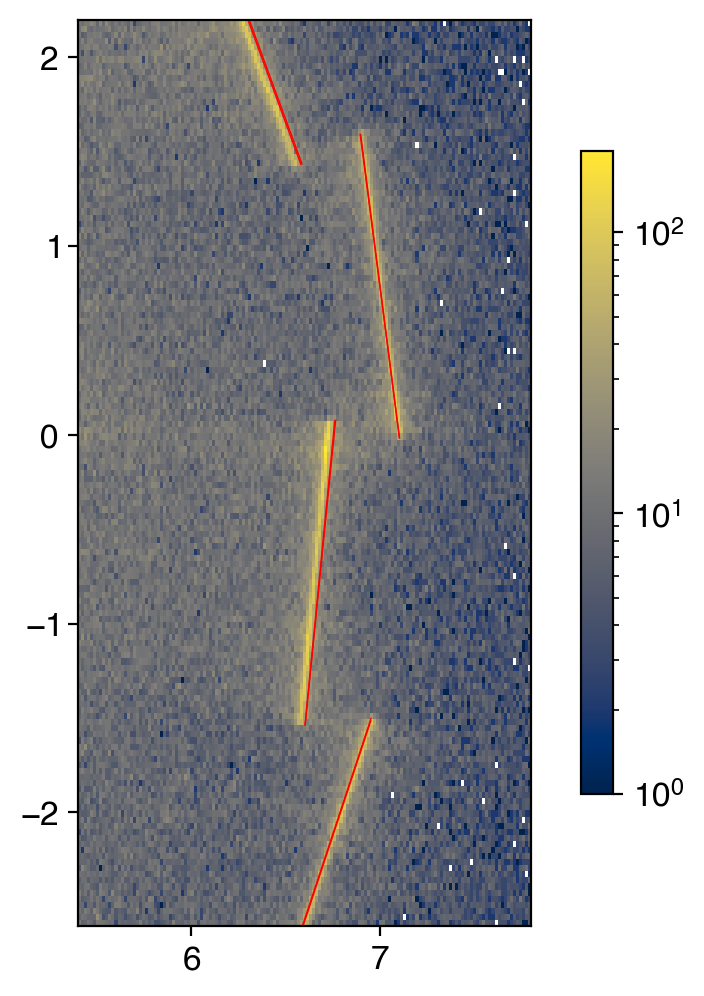

In [114]:
%%time
bins = [
#     np.linspace(6.4,6.8,100),np.linspace(-1.6,0.2,100),
    np.linspace(5.4,7.8,150),np.linspace(-2.6,2.2,150),
#     np.linspace(6.8,7.2,100),np.linspace(-0.2,1.8,150),
]
tdf = df.query("({} < DV_x < {}) and ({} < DV_y < {})".format(
    bins[0][0],bins[0][-1],bins[1][0],bins[1][-1]
)).compute()

counts = np.histogram2d(tdf.DV_x,tdf.DV_y,bins=bins)[0]
fig,ax = plt.subplots(figsize=(6,6))
utils.plot_overlay_bpix(ax,color="r",lw=0.5)
H = ax.imshow(
    counts[::,::-1].T,
    cmap="cividis",
    norm=LogNorm(),
    extent=[
        bins[0][0],bins[0][-1],
        bins[1][0],bins[1][-1],
    ],
    interpolation="none",
      )
fig.colorbar(H,ax=ax,shrink=0.71)


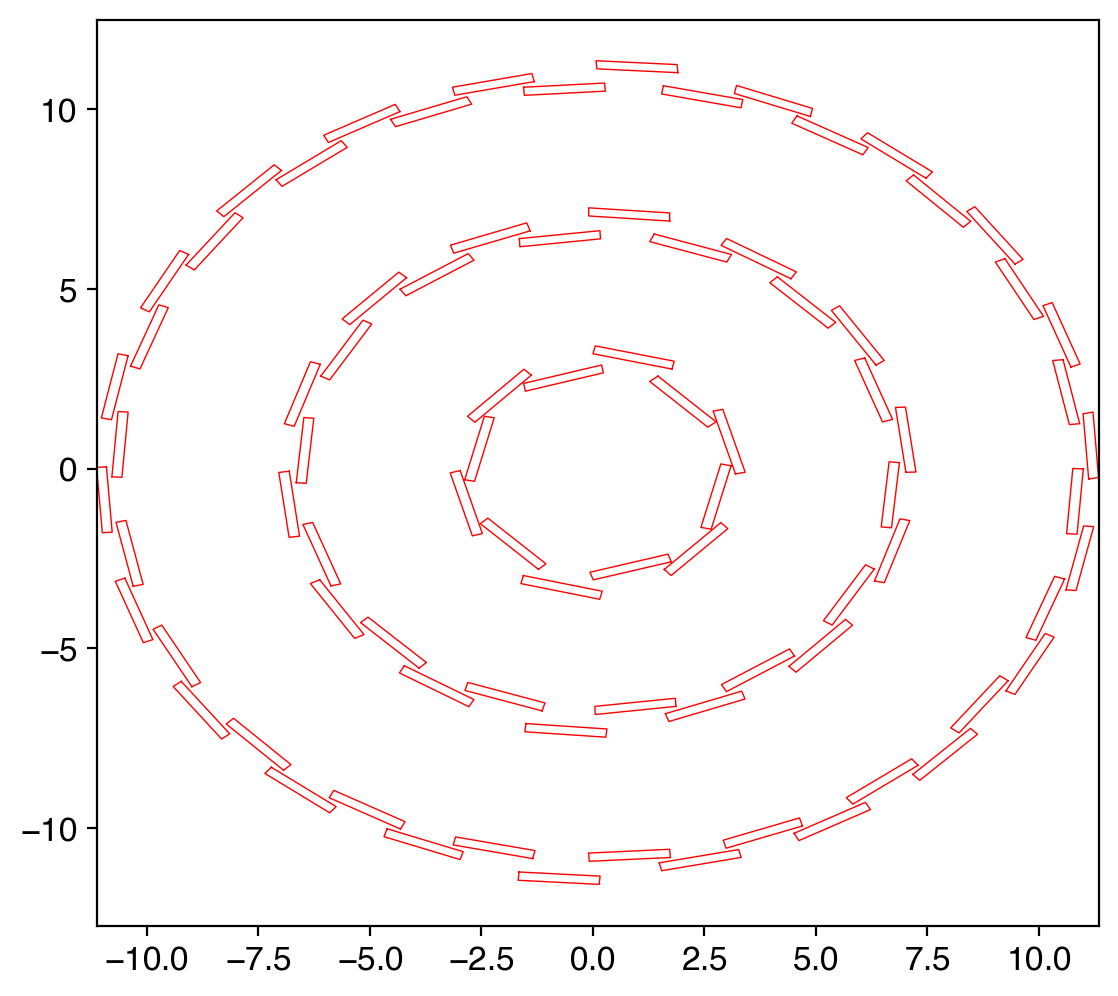

In [7]:
fig,ax = plt.subplots(figsize=(6,6))
utils.plot_overlay_bpix(ax,color="r",lw=0.5,expand_h=0.1)


<IPython.core.display.Javascript object>


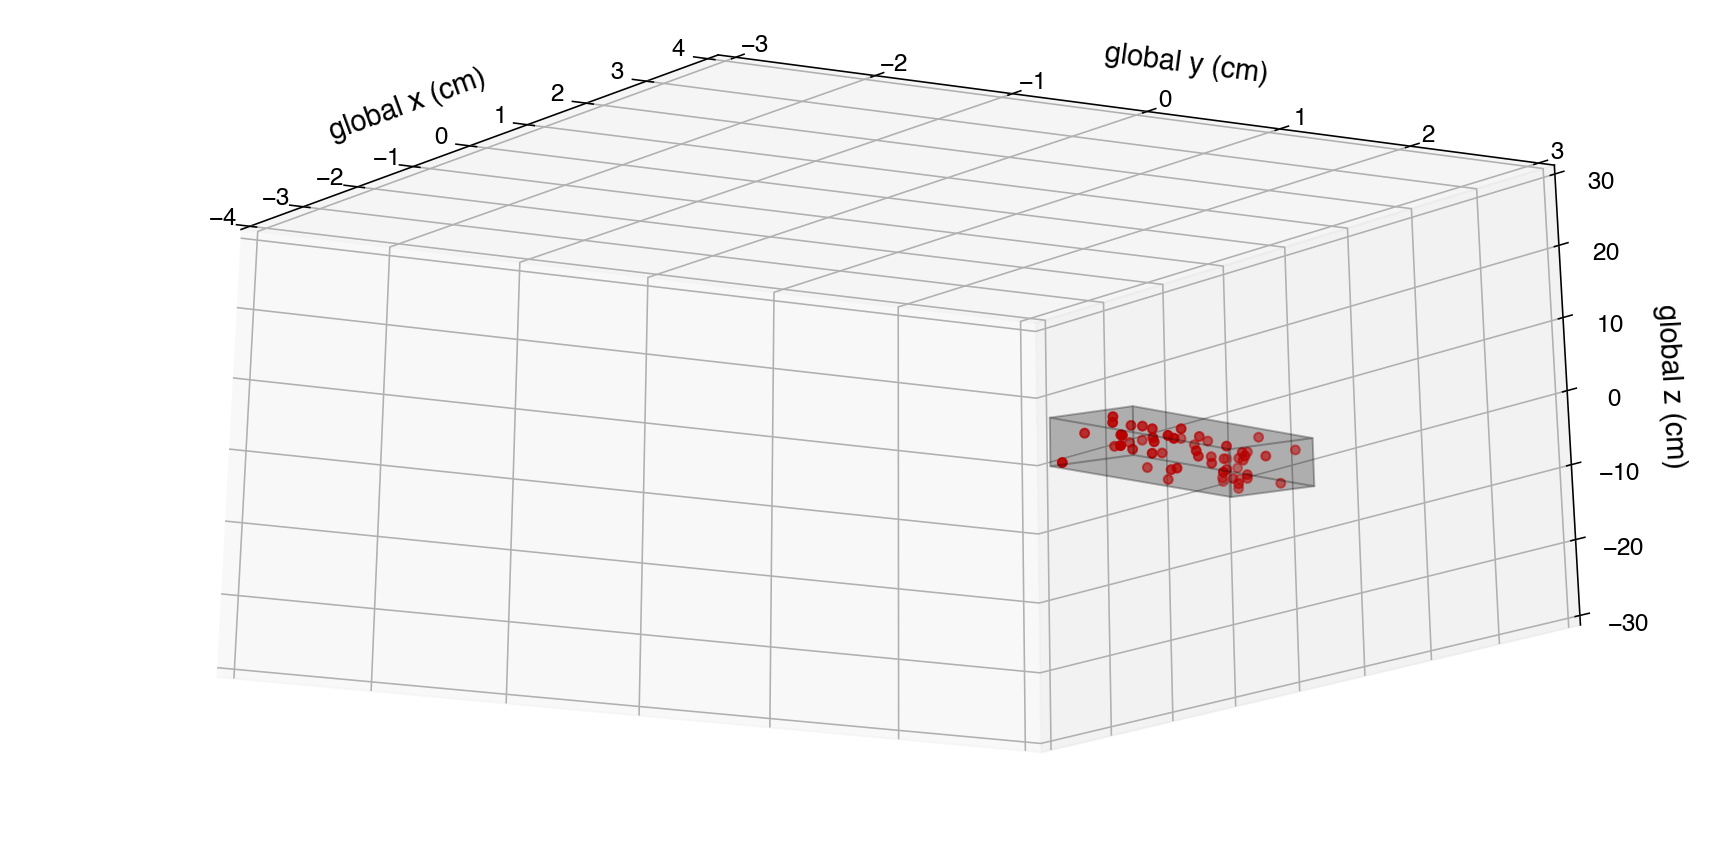

[0.81    3.24    0.41425]
[array([-0.81      , -3.23999991, -0.41425   ]), array([-0.80999999, -3.23999991,  0.41424998]), array([-0.81      ,  3.23999991, -0.41425   ]), array([-0.80999999,  3.23999991,  0.41424998]), array([ 0.80999999, -3.23999991, -0.41424998]), array([ 0.81      , -3.23999991,  0.41425   ]), array([ 0.80999999,  3.23999991, -0.41424998]), array([0.81      , 3.23999991, 0.41425   ])]


(-30, 30)

In [251]:
%matplotlib notebook
# enables interactivity

fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)

ax = Axes3D(fig,azim=-30,elev=15)

for irow,entry in gdf.query("abs(translation_z)<15").iterrows():
# for irow,entry in gdf.query("abs(translation_z)>35").iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)

    newshape = np.array(shape)
    newshape[-1] += 0.4 # add 0.1cm to the thickness
    shape = newshape
    
    points = shape.T * step_directions

    newpoints = np.array([np.dot(matrix,point)+translation for point in points])
    
    newpoints = np.array([np.dot(matrix,point)+translation for point in points])
    print(shape.T)
    print([np.dot(matrix.T,point-translation) for point in newpoints])

    # edges of each face shouldn't cross, so we look at our binary matrix
    # and get the indices of elements which will give an ordering that goes CCW
    # (e.g., for fixed z (3rd column=0 or 1), xy should do 00,10,11,01)
    faces = [
        newpoints[np.array([0,2,3,1])],
        newpoints[np.array([4,6,7,5])],
        newpoints[np.array([0,4,5,1])],
        newpoints[np.array([2,6,7,3])],
        newpoints[np.array([0,4,6,2])],
        newpoints[np.array([1,5,7,3])],
    ]
    faces = np.array(faces)
    
    # rotate x,y,z because I can't make matplotlib z axis go horizontally
    newfaces = np.array(faces)
    faces = newfaces
    
    
    color = "C3"
    if abs(entry.translation_z) > 27:
        color = "C0" 
    elif entry.translation_rho < 5:
        color = "k"
    elif entry.translation_rho < 10:
        color = "C2"
    elif entry.translation_rho < 15:
        color = "C1"
    ax.add_collection3d(Poly3DCollection(faces,alpha=0.15,color=color))
    break
    
N = 500
np.random.seed(42)

xs = np.random.random(N)*2+2
ys = np.random.random(N)*4-2
zs = np.random.random(N)*10-15

# xs = np.random.random(N)*5+5
# ys = np.random.random(N)*3-1
# zs = np.random.random(N)*5+35

isin = []
for x,y,z in zip(xs,ys,zs):
    cand = np.array([x,y,z])
    isin.append((np.abs(np.dot(matrix.T,cand-translation)) < shape).sum()==3)
isin = np.array(isin,dtype=np.bool)
ax.scatter(xs[isin], ys[isin], zs[isin], marker="o", color="r")
# ax.scatter(xs[~isin], ys[~isin], zs[~isin], marker=".", color="k",alpha=0.3)

ax.grid()
ax.set_xlabel("global x (cm)")
ax.set_ylabel("global y (cm)")
ax.set_zlabel("global z (cm)")

ax.set_xlim([-4,4])
ax.set_ylim([-3,3])
ax.set_zlim([-30,30])

# ax.set_xlim([5,10])
# ax.set_ylim([-1,2])
# ax.set_zlim([35,40])

In [8]:
%%time

shapes = []
translations = []
rotations = []
for irow,entry in gdf.iterrows():
    shape = entry["shape"][1:-1]
    translation = entry["translation"]
    matrix = entry["matrix"].reshape(3,3)
    
    # add 0.2cm to all dimensions, except 0.4cm to radial
    newshape = np.array(shape.T)
    newshape[0] += 0.2 # 
    newshape[1] += 0.2 # 
    newshape[2] += 0.5 # thickness
    
    shapes.append(newshape)
    translations.append(translation)
    rotations.append(matrix.T)
shapes = np.array(shapes,dtype=np.float32)
translations = np.array(translations,dtype=np.float32)
rotations = np.array(rotations,dtype=np.float32)


print(shapes.nbytes)
print(translations.nbytes)
print(rotations.nbytes)

22272
22272
66816
CPU times: user 380 ms, sys: 20 ms, total: 400 ms
Wall time: 396 ms


1.106468677520752


(-10, 10)

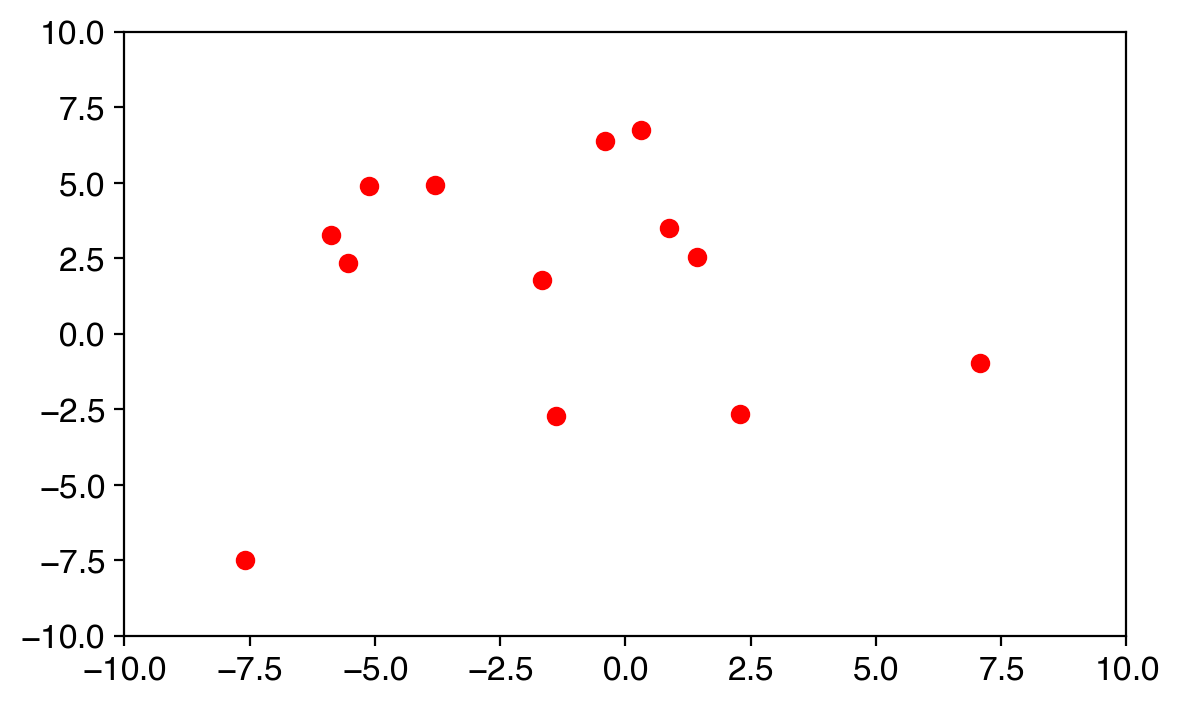

In [9]:
import time

@numba.njit()
def is_point_in_pixel(x,y,z):
    # pure python (numba) runs at about 300Hz (6kHz) on 1cm skim 
    # (so it's much faster when not skimming because we'd skip the <1cm guys)
    rho = (x**2 + y**2)**0.5
    if abs(z) < 23:
        if rho < 2.3: return False
        if 3.7 < rho < 6.0: return False
    cand = np.array([x,y,z],dtype=np.float32)
    for i in range(len(shapes)):
        shape = shapes[i]
        translation = translations[i]
        rotation = rotations[i]
        shifted = cand-translation
        untransformed_cand = np.dot(rotation,shifted)
        is_inside = (np.abs(untransformed_cand) < shape).sum()==3
        if is_inside: return True
    return False

N = 50
xs = np.random.normal(0,5,N)
ys = np.random.normal(0,5,N)
zs = np.random.normal(0,5,N)

fig,ax = plt.subplots()
isin = []
t0 = time.time()
for x,y,z in zip(xs,ys,zs):
    isin.append(is_point_in_pixel(x,y,z))
t1 = time.time()
print(t1-t0)
isin = np.array(isin,dtype=bool)
ax.scatter(xs[isin],ys[isin],color="r")

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])

In [10]:
%%time
is_point_in_pixel(3.0,0,0)

CPU times: user 513 ms, sys: 6 ms, total: 519 ms
Wall time: 518 ms


True

In [11]:
# %%time
# for _ in range(1000):
#     is_point_in_pixel(3.0,0,0)

In [12]:
df_data = pd.read_pickle("data/df_data.pkl")

In [13]:
isin_big = []
for x,y,z in tqdm(df_data[["DV_x","DV_y","DV_z"]].values):
    isin_big.append(is_point_in_pixel(x,y,z))
isin_big = np.array(isin_big,dtype=bool)

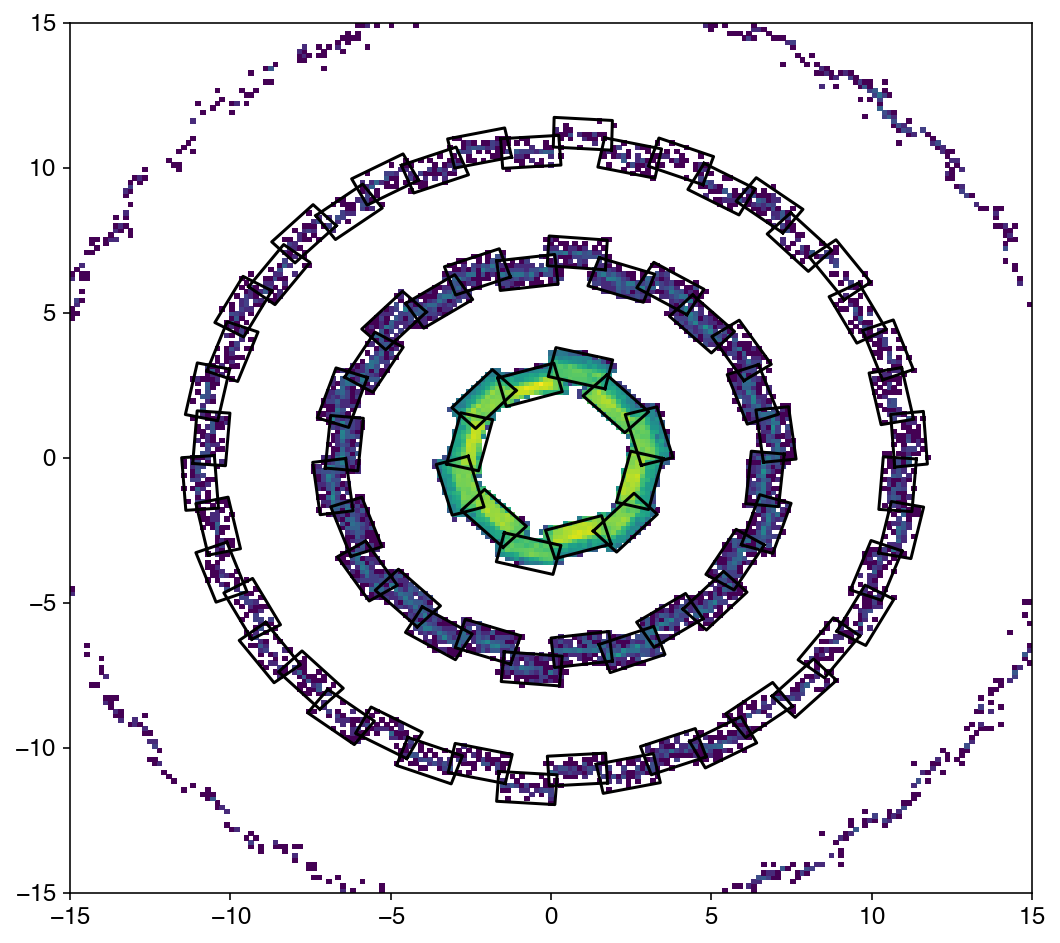

In [34]:
sel = np.abs(df_data.DV_z) < 27.
fig,ax = plt.subplots(figsize=(8,8))
ax.hist2d(
#     df_data.DV_x[~isin_big & sel],
#     df_data.DV_y[~isin_big & sel],
    df_data.DV_x[isin_big & sel],
    df_data.DV_y[isin_big & sel],
    bins=[np.linspace(-15,15,200),np.linspace(-15,15,200)],
    norm=LogNorm(),
);

utils.plot_overlay_bpix(ax,color="k",expand_h=0.5)

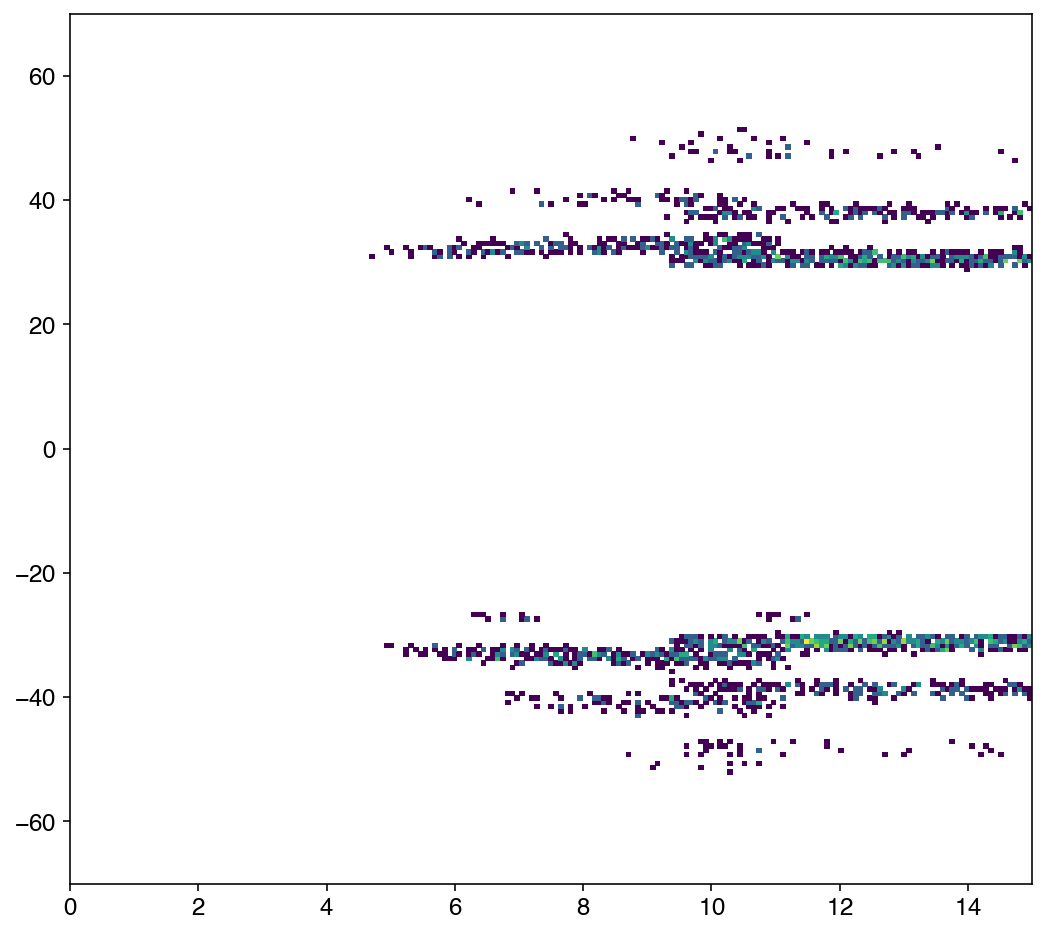

In [36]:
sel = np.abs(df_data.DV_z) > 27.
fig,ax = plt.subplots(figsize=(8,8))
ax.hist2d(
    df_data.DV_rho[isin_big & sel],
    df_data.DV_z[isin_big & sel],
    bins=[np.linspace(0,15,200),np.linspace(-70,70,200)],
    norm=LogNorm(),
);


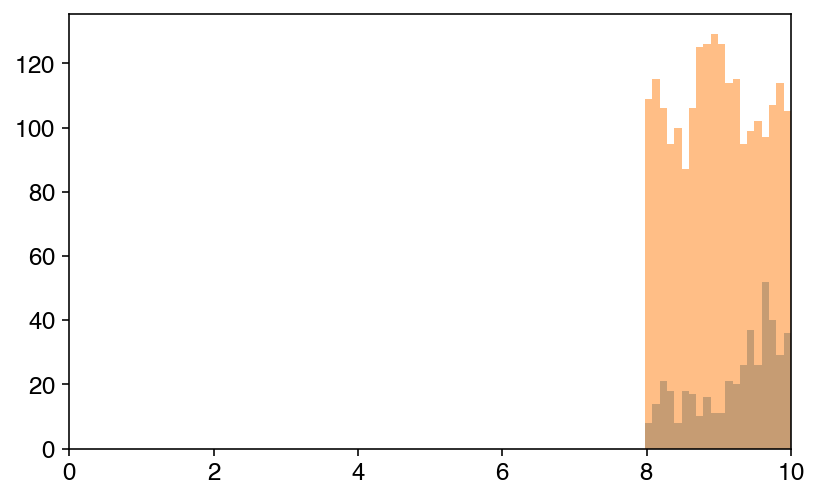

In [21]:
%matplotlib inline
fig,ax = plt.subplots()
sel = (df_data.DV_rho > 8.0)
ax.hist(df_data.DV_rho[isin_big & sel],bins=np.linspace(0,10,100),alpha=0.5);
ax.hist(df_data.DV_rho[~isin_big & sel],bins=np.linspace(0,10,100),alpha=0.5);
# ax.set_yscale("log")

In [31]:
from scipy.stats import pearsonr
sel = np.abs(df_data.DV_z)>30.
pearsonr(
    df_data.DV_inPixelRectangles[sel],
    isin_big[sel],
)

(0.5803874688981755, 0.0)